<div style="padding-bottom: 8%">
    <div style="width: 20%; float: left"><img src="https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2F1000logos.net%2Fwp-content%2Fuploads%2F2017%2F08%2FSpotify-Logo.png&f=1&nofb=1" alt="Spotify Logo"></div>
<center>
    <h1 style="padding-top: 5%"><b>How gender might be impacting your music choices</b></h1>
    </center>
</div>

<center><h3><b>by Joseph Davies</b></h3></center>

## Introduction

Music is something very important to just about everyone. In popular culture, it's common for people to make judgments about your personality based on your music taste. As a (non-scientific) example, this can easily be seen on comment sections of catchy songs that have become popular, where guys will praise the song, but imply that it would be too embarrassing to share with their guy friends, since that would ruin their manly image:

<center> <img src="pic1.png" alt="This is that one song you listen to alone without the boys"> </center>
<br/>
<center> <img src="pic2.png" style="text-align: center" alt="Don't tell the homies im listening to this"> </center> 
<br/>

This tendency is really interesting to me, as my music taste tends to prefer female vocalists. Is my taste really that exceptional among men, or could this in part be based more on how we present ourselves to the world? That is to say, maybe men *do* listen to "feminine" music more often than they might let on, but that isn't something they present to the world.

Some questions that might naturally lead from this could include questions like: 

- Do men tend to listen less to music by women/non-binary artists (and vice versa)?
- Do they tend to gravitate towards male artists more when genres are female-dominated?

With services like Spotify having publicly available APIs, a lot of data on listening patterns have been collected from users' listening histories. So, we can take a look at this data to attempt to at least partially answer these questions.

In [28]:
# Importing packages
import requests as req
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Data Collection
The information in this project is scraped from [Every Noise at Once](https://everynoise.com/), which compiles data from Spotify and does a lot of cool analysis with it. For example, it can compare genres' similarity, acousticness, Christmassy-ness, modernness, youthfulness, engagement, etc. It's a very cool tool.

(Side note: I was originally going to make this a project comparing data from here and a site called rateyourmusic, but rateyourmusic IP banned me for attempting to web scrape!) 

Specifically, we'll be scraping from their page on [gender-based listening patterns by genre](https://everynoise.com/tview.cgi?source=gender_listening_patterns).

First, we'll use `requests` to get the webpage we want, then we will use BeautifulSoup to get the table we want from it, then feed that to the panda we stole from the zoo:

In [29]:
gender_patterns = req.get('https://everynoise.com/tview.cgi?source=gender_listening_patterns&sort=poprank&colorthis=true')

In [30]:
soup = BeautifulSoup(gender_patterns.content, 'html.parser')
soup = soup.find("table")

In [31]:
df = pd.read_html(str(soup))[0]
df.head()

,0,1,2,3,4,5,6,7,8
0,#,genre,female listeners,female streams,gender tilt,ffshare,mfshare,shareskew,poprank
1,1,pop,0.617,0.514,0.103,0.548,0.443,0.105,1
2,2,dance pop,0.602,0.608,-0.006,0.646,0.524,0.122,2
3,3,post-teen pop,0.681,0.643,0.038,0.659,0.617,0.042,3
4,4,rap,0.276,0.030,0.246,0.062,0.025,0.037,4


# Tidying up
Looking good so far, but the column names are in the first row, the first column already has its job done by our indices, and the last row is not data, so let's clean all that stuff up:

In [32]:
df = pd.DataFrame(df.values[1:], columns=df.iloc[0])
df.head()

,#,genre,female listeners,female streams,gender tilt,ffshare,mfshare,shareskew,poprank
0,1,pop,0.617,0.514,0.103,0.548,0.443,0.105,1
1,2,dance pop,0.602,0.608,-0.006,0.646,0.524,0.122,2
2,3,post-teen pop,0.681,0.643,0.038,0.659,0.617,0.042,3
3,4,rap,0.276,0.030,0.246,0.062,0.025,0.037,4
4,5,rock,0.316,0.077,0.239,0.105,0.068,0.037,5


In [33]:
df = df.drop(['#'], axis=1)

In [34]:
df = df[:-1]
df.head()

,genre,female listeners,female streams,gender tilt,ffshare,mfshare,shareskew,poprank
0,pop,0.617,0.514,0.103,0.548,0.443,0.105,1
1,dance pop,0.602,0.608,-0.006,0.646,0.524,0.122,2
2,post-teen pop,0.681,0.643,0.038,0.659,0.617,0.042,3
3,rap,0.276,0.030,0.246,0.062,0.025,0.037,4
4,rock,0.316,0.077,0.239,0.105,0.068,0.037,5


# What the columns mean
[According to Every Noise](https://everynoise.com/tview.cgi?source=gender_listening_patterns&sort=poprank&colorthis=true), the columns are defined as follows (these descriptions are also from that page):
- Genre is self-explanatory
- Female listeners refers to the fraction of genre listeners who identify as female
- Female streams refers to the fraction of genre streams by female or mixed-gender artists (mixed-gender likely referring to non-binary and intersex artists)
- Gender tilt compares female listeners and female streams, so positive gender tilt identifies genres that tend to have women listening to men, and negative gender tilt identifies genres that tend to have men listening to women
- "ffshare" and "mfshare" are the average fractions of each listener's streams that are of female or mixed-gender artists, aggregated by listener gender
- "shareskew" compares ffshare to mfshare, so positive shareskew identifies genres where female listeners play female artists more than male listeners do, which is most of them
- "poprank" is the order of genres by Spotify streamshare

When references are made to female streams or female artists from here on out, this includes nonbinary artists, even though that is a different group of people altogether - this is just how the data is organized. However, the groups of listeners are only categorized into male and female.

With this information we have a lot of different factors we can assess by. Let's start!

We mainly want to focus on the most popular genres, so we're going to only look at the 300 most listened to genres for data. Because our data is already sorted by popularity, we can just take the first 300 rows.

In [36]:
df = df[:300]
df.head()

,genre,female listeners,female streams,gender tilt,ffshare,mfshare,shareskew,poprank
0,pop,0.617,0.514,0.103,0.548,0.443,0.105,1
1,dance pop,0.602,0.608,-0.006,0.646,0.524,0.122,2
2,post-teen pop,0.681,0.643,0.038,0.659,0.617,0.042,3
3,rap,0.276,0.030,0.246,0.062,0.025,0.037,4
4,rock,0.316,0.077,0.239,0.105,0.068,0.037,5


This data is all currently stored as strings since we got it from a web scrape, so let's convert it into numbers to analyze:

In [37]:
df = df.apply(pd.to_numeric, errors='ignore')

Before we go any further, we should check for missing data and see what we need to do to account for it from there:

In [38]:
df[df.isnull().values.any(axis=1)]

,genre,female listeners,female streams,gender tilt,ffshare,mfshare,shareskew,poprank


Extremely fortunately for us, we do not have any missing data.

# Exploratory data analysis and Machine Learning

The first thing we might want to look at is the rate of female listeners to the rate of female streams to see if there is a correlation between gender and listening preferences.

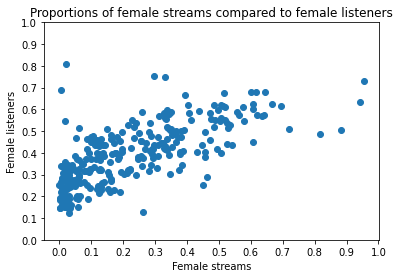

In [39]:
# To prevent unnecessary rewriting when we add our regression later
def listeners_to_streams():
    fig, ax = plt.subplots()
    plt.scatter(df[['female streams']], df[['female listeners']])
    ax.set_xlabel('Female streams')
    ax.set_ylabel('Female listeners')
    ax.set_xticks(np.linspace(0.0, 1.0, num=11))
    ax.set_yticks(np.linspace(0.0, 1.0, num=11))
    ax.set_ylim(0,1)
    ax.set_title('Proportions of female streams compared to female listeners')

listeners_to_streams()

### First thoughts
Here we have our first visualization of some data. As we can see, there does seem to be a correlation between the proportion of female listeners and female artists. This would suggest that, the higher the proportion of women or non-binary artists there are in a given genre, the higher the proportion of listeners that are also women.

If we want to make better predictions for this data though, it doesn't seem like a linear regression would work, since the data seems to bunch up a lot at the left up to a certain point, where there are genres that have near-zero female/nonbinary artists but a fair amount of female listeners. One example of this in our dataset is with the genre "rap," which has a 3% share of female/nonbinary artists with a 27.6% share of female listeners. 

Indeed, the data seems to curve, so a nonlinear regression might give us better insight. For this part, I found [this guide](https://towardsdatascience.com/polynomial-regression-the-only-introduction-youll-need-49a6fb2b86de) extremely helpful, and the code for this block has heavily borrowed (and adjusted) from it.

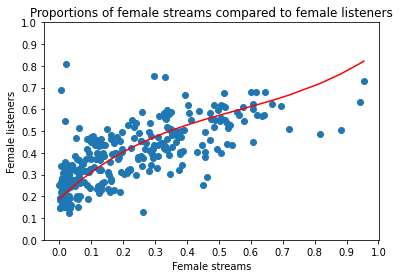

In [46]:
x_train = df[['female streams']].values
y_train = df[['female listeners']].values

x_train = x_train[x_train[:, 0].argsort()]
y_train = y_train[y_train[:, 0].argsort()]

poly = PolynomialFeatures(3)
x_poly = poly.fit_transform(x_train)

poly_reg = linear_model.LinearRegression()

poly_reg.fit(x_poly, y_train)

listeners_to_streams()
plt.plot(x_train, poly_reg.predict(x_poly), color='red')

Also, we should evaluate our R-squared score to check how well we have fit the data:

In [47]:
poly_reg.score(x_poly, y_train)

0.9799605869317595

That looks very good, so we can assume that we have made an appropriate fit with our data.

Just for fun, let's look at where the top 5 most listened-to genres exist on this chart. We can annotate them on the graph to find out (while not plotting the rest of the points, so we can get a clearer look)

In [48]:
most_popular = df[:5]['genre']
most_popular

0              pop
1        dance pop
2    post-teen pop
3              rap
4             rock
Name: genre, dtype: object

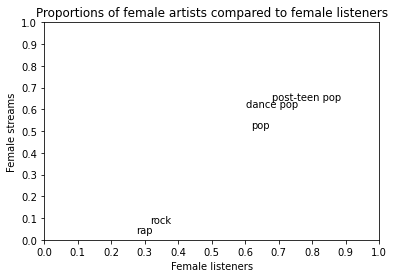

In [49]:
fig, ax = plt.subplots()
ax.set_xlabel('Female listeners')
ax.set_ylabel('Female streams')
ax.set_title('Proportions of female artists compared to female listeners')
ax.set_xticks(np.linspace(0.0, 1.0, num=11))
ax.set_yticks(np.linspace(0.0, 1.0, num=11))

# This annotates the 5 most popular genres
for i in range(most_popular.size):
    row_in_question = df[df['genre'] == most_popular[i]]
    x = row_in_question['female listeners']
    y = row_in_question['female streams']
    plt.annotate(most_popular[i], (x, y))

plt.show()

Another set of comparisons we could look at is how the proportion of female streams compares with the 'ffshare' and 'mfshare' variables we have. As defined earlier, 'ffshare' refers to the share of streams women listening to a genre listen to from women and nonbinary artists, and likewise, 'mfshare' refers to the share of streams men listening to a genre listen to from women and nonbinary artists. 

Like before, we'll also plot where the top 5 most listened to genres factor into this.

This could also suggest whether men listen to men in a given genre more than women do, which ties back to what we wanted to figure out from the start.

For this data, we'll fit linear regressions.

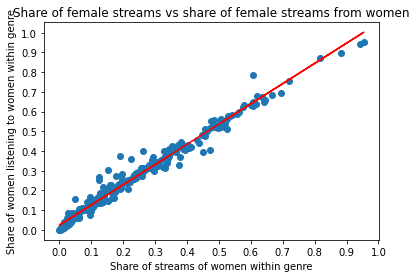

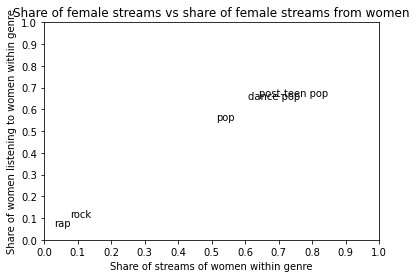

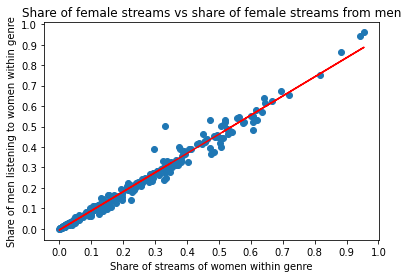

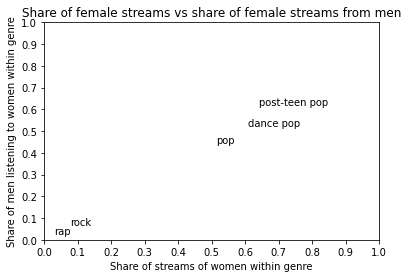

In [51]:
# Plot of female streams vs. ffshare
def streams_ffshare_setup():
    fig, ax = plt.subplots()    
    ax.set_xlabel('Share of streams of women within genre')
    ax.set_ylabel('Share of women listening to women within genre')
    ax.set_xticks(np.linspace(0.0, 1.0, num=11))
    ax.set_yticks(np.linspace(0.0, 1.0, num=11))
    ax.set_title('Share of female streams vs share of female streams from women')

streams_ffshare_setup()
plt.scatter(df[['female streams']], df[['ffshare']])

lreg = linear_model.LinearRegression()
m, b = np.polyfit(df['female streams'], df['ffshare'], 1)
plt.plot(df[['female streams']], m * df[['female streams']] + b, color='red')

plt.show()

# Same plot as before, but only the top 5 genres
streams_ffshare_setup()

for i in range(most_popular.size):
    row_in_question = df[df['genre'] == most_popular[i]]
    x = row_in_question['female streams']
    y = row_in_question['ffshare']
    plt.annotate(most_popular[i], (x, y))
    
plt.show()

# Plot of female streams vs. mfshare
def streams_mfshare_setup():
    fig, ax = plt.subplots()
    ax.set_xlabel('Share of streams of women within genre')
    ax.set_ylabel('Share of men listening to women within genre')
    ax.set_xticks(np.linspace(0.0, 1.0, num=11))
    ax.set_yticks(np.linspace(0.0, 1.0, num=11))
    ax.set_title('Share of female streams vs share of female streams from men')

streams_mfshare_setup()
plt.scatter(df[['female streams']], df[['mfshare']])

lreg = linear_model.LinearRegression()
m, b = np.polyfit(df['female streams'], df['mfshare'], 1)
plt.plot(df[['female streams']], m * df[['female streams']] + b, color='red')

plt.show()

# Same plot as before, but only the top 5 genres
streams_mfshare_setup()

for i in range(most_popular.size):
    row_in_question = df[df['genre'] == most_popular[i]]
    x = row_in_question['female streams']
    y = row_in_question['mfshare']
    plt.annotate(most_popular[i], (x, y))
    
plt.show()

These graphs look fairly similar, and seem to say that, generally, neither men nor women deviate that much from the average listener. However, this is not the case for every genre. For example, one of the most listened to genres, pop rap, has a more than 20% share difference between the two groups.

Overall, though, to get a better idea of these patterns, what if we looked at the difference between men and women's listening patterns? Thankfully, we already have the "shareskew" variable to do this.

As a kind of control, we should also look at differences men and women have with the overall average, as it will likely tell us a good amount more than the previous two graphs we made. Positive values here would mean that that group listens to women/non-binary artists more than average (and negative values the opposite.)

Sadly, as mentioned before, it seems that nonbinary listeners don't have their listening habits documented in this dataset, so we can't look at their data. :(

In [44]:
df['mf_overall_diff'] = df['mfshare'] - df['female streams']
df['ff_overall_diff'] = df['ffshare'] - df['female streams']
df.head()

,genre,female listeners,female streams,gender tilt,ffshare,mfshare,shareskew,poprank,mf_overall_diff,ff_overall_diff
0,pop,0.617,0.514,0.103,0.548,0.443,0.105,1,-0.071,0.034
1,dance pop,0.602,0.608,-0.006,0.646,0.524,0.122,2,-0.084,0.038
2,post-teen pop,0.681,0.643,0.038,0.659,0.617,0.042,3,-0.026,0.016
3,rap,0.276,0.030,0.246,0.062,0.025,0.037,4,-0.005,0.032
4,rock,0.316,0.077,0.239,0.105,0.068,0.037,5,-0.009,0.028


Now, let's plot our information to visualize how men and women measure up to the average listener, and to each other! We'll also see how this looks for the 5 most popular genres.

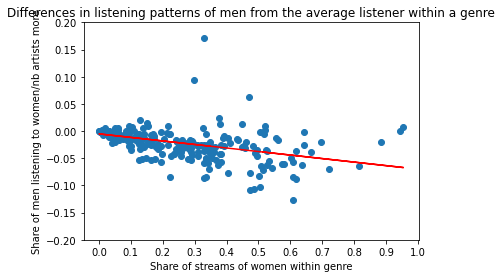

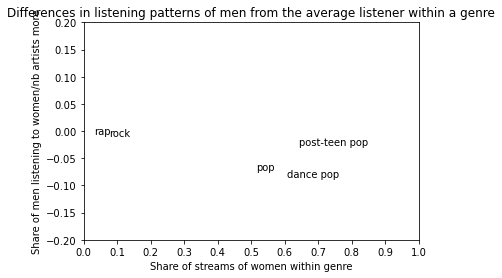

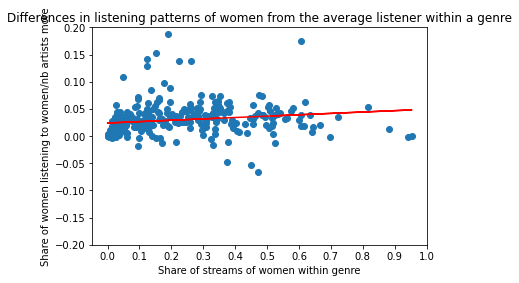

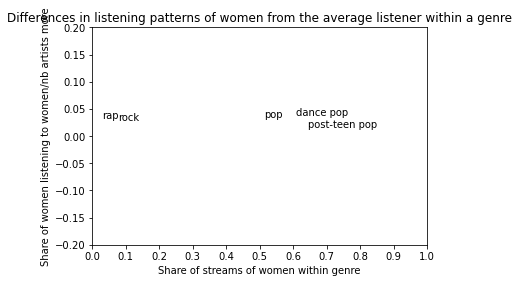

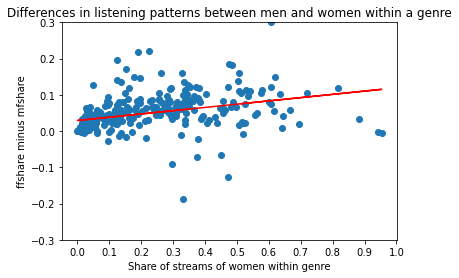

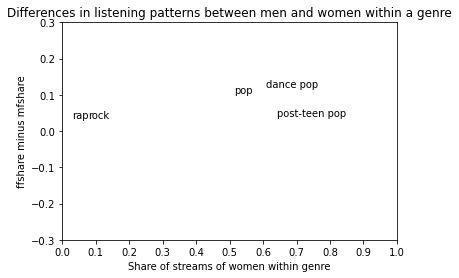

In [45]:
def femstream_mf_overall_setup():
    fig, ax = plt.subplots()
    ax.set_xlabel('Share of streams of women within genre')
    ax.set_ylabel('Share of men listening to women/nb artists more')
    ax.set_xticks(np.linspace(0.0, 1.0, num=11))
    ax.set_ylim(-0.2,0.2)
    ax.set_title('Differences in listening patterns of men from the average listener within a genre')

femstream_mf_overall_setup()
plt.scatter(df[['female streams']], df[['mf_overall_diff']])

m, b = np.polyfit(df['female streams'], df['mf_overall_diff'], 1)
plt.plot(df[['female streams']], m * df[['female streams']] + b, color='red')
plt.show()

# Same plot as before, but only the top 5 genres
femstream_mf_overall_setup()

for i in range(most_popular.size):
    row_in_question = df[df['genre'] == most_popular[i]]
    x = row_in_question['female streams']
    y = row_in_question['mf_overall_diff']
    plt.annotate(most_popular[i], (x, y))
    
plt.show()

def femstream_ff_overall_setup():
    fig, ax = plt.subplots()
    ax.set_xlabel('Share of streams of women within genre')
    ax.set_ylabel('Share of women listening to women/nb artists more')
    ax.set_xticks(np.linspace(0.0, 1.0, num=11))
    ax.set_ylim(-0.2,0.2)
    ax.set_title('Differences in listening patterns of women from the average listener within a genre')

femstream_ff_overall_setup()
plt.scatter(df[['female streams']], df[['ff_overall_diff']])

m, b = np.polyfit(df['female streams'], df['ff_overall_diff'], 1)
plt.plot(df[['female streams']], m * df[['female streams']] + b, color='red')

plt.show()

# Same plot as before, but only the top 5 genres
femstream_ff_overall_setup()

for i in range(most_popular.size):
    row_in_question = df[df['genre'] == most_popular[i]]
    x = row_in_question['female streams']
    y = row_in_question['ff_overall_diff']
    plt.annotate(most_popular[i], (x, y))
    
plt.show()

def mf_ff_overall_setup():
    fig, ax = plt.subplots()
    ax.set_xlabel('Share of streams of women within genre')
    ax.set_ylabel('ffshare minus mfshare')
    ax.set_xticks(np.linspace(0.0, 1.0, num=11))
    ax.set_ylim(-0.3,0.3)
    ax.set_title('Differences in listening patterns between men and women within a genre')

mf_ff_overall_setup()
plt.scatter(df[['female streams']], df[['shareskew']])

m, b = np.polyfit(df['female streams'], df['shareskew'], 1)
plt.plot(df[['female streams']], m * df[['female streams']] + b, color='red')

plt.show()

# Same plot as before, but only the top 5 genres
mf_ff_overall_setup()

for i in range(most_popular.size):
    row_in_question = df[df['genre'] == most_popular[i]]
    x = row_in_question['female streams']
    y = row_in_question['shareskew']
    plt.annotate(most_popular[i], (x, y))
    
plt.show()

Looking at these graphs, we can observe an interesting relationship: the higher the share of streams by a female artist there are, the more that male listeners skew toward listening to male artists than the average. For female listeners, the opposite pattern seems to hold, but to a much weaker degree, as the linear regression we generated has a much flatter incline.

The last graph, which shows the difference between genders, subtracts the male share from the female share, so this means that a positive value indicates that women's streams of a genre are more female-saturated than men's streams of the same genre. The general pattern seems to follow from the past observed patterns: that men and women's listening patterns grow more and more disparate the more female-saturated a genre becomes. Also from the past observations, we could claim that the difference is more driven by male listeners than female listeners, since their listening patterns become more and more male-skewed at a faster rate than women's listening patterns become more and more female-skewed.

# Conclusion

From all of this, we can see that there are differences between men and women's listening patterns, and that those differences grow the more female-saturated a genre is. Similarly, when a genre has more women listening to it, it also tends to have a higher share of its streams be from women and nonbinary artists. However, these tendencies are a bit weaker than I initially suspected they would be. 

Going back to the questions we asked at the start:

1. Do men tend to listen less to music by women/non-binary artists (and vice versa)?

Generally, yes. As we saw, the more female-saturated a genre was, the more female-saturated its listener base was.

2. Do men tend to gravitate towards male artists when genres are female-dominated?

Also yes--but not to a huge degree. As genres became more and more female-saturated, male and female listeners tended to listen to more artists from their own gender, approaching at most a difference in 5% of streams in both cases (though female listeners listen to about the same amount more from female artists across the board, only very slightly climbing, while male listeners' tendencies vary  more based on the female-saturation in the genre.)

If you would like to check out the Every Noise at Once database and maybe make some analyses of your own, you can check it out and navigate through it [here](https://everynoise.com).

In the process of working on this, I listened to the following albums:

- Explosions in the Sky - The Earth is Not a Cold Dead Place
- Susanne Sundfør - The Brothel
- Many, many songs from Ichiko Aoba's discography
- Susanne Sundfør - Ten Love Songs (multiple times)
- George Clanton - Slide
- Hannah Diamond - Reflections
- Depeche Mode - Violator